In [1]:
!pip install deeplake
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 134.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import deeplake

In [3]:
ds_train = deeplake.load("hub://activeloop/lsp-train")
ds_test = deeplake.load("hub://activeloop/lsp-test")

dataloader_train = ds_train.tensorflow()
dataloader_test = ds_test.tensorflow()

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-train



\

hub://activeloop/lsp-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/lsp-test



\

hub://activeloop/lsp-test loaded successfully.



In [4]:
def normalize_keypoints(keypoints, bounding_box):
    norm_keypoints = np.copy(keypoints)
    norm_keypoints[:, 0] = (norm_keypoints[:, 0] - bounding_box[0]) / bounding_box[2]
    norm_keypoints[:, 1] = (norm_keypoints[:, 1] - bounding_box[1]) / bounding_box[3]
    return norm_keypoints

In [5]:
def unnormalize_keypoints(keypoints,bounding_box):
    keypoints[:,0] = (keypoints[:,0]*bounding_box[2]) + bounding_box[0]
    keypoints[:,1] = (keypoints[:,1]*bounding_box[3]) + bounding_box[1]
    keypoints[:,0] = np.clip(keypoints[:,0],0,bounding_box[2])
    keypoints[:,1] = np.clip(keypoints[:,1],0,bounding_box[3])
    return keypoints.astype(np.int32)

In [6]:
def visualize_keypoints(image,keypoints,image_visualized):
    height,width = image_visualized.shape[:2]
    try:
        image = cv2.resize(image.numpy(),(width,height))
    except:
        image = cv2.resize(image,(width,height))
    fig , ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(image)
    ax.scatter(keypoints[:,0],keypoints[:,1])
    for i in range(keypoints.shape[0]):
        ax.annotate(str(i), (keypoints[i,0],keypoints[i,1]),fontsize=10)
    for i in range(0,5):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(6,11):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    for i in range(12,13):
        ax.plot([keypoints[i,0],keypoints[i+1,0]],[keypoints[i,1],keypoints[i+1,1]],linewidth=5)
    plt.show()

In [7]:
batch_iter = iter(dataloader_train)
batch = next(batch_iter)

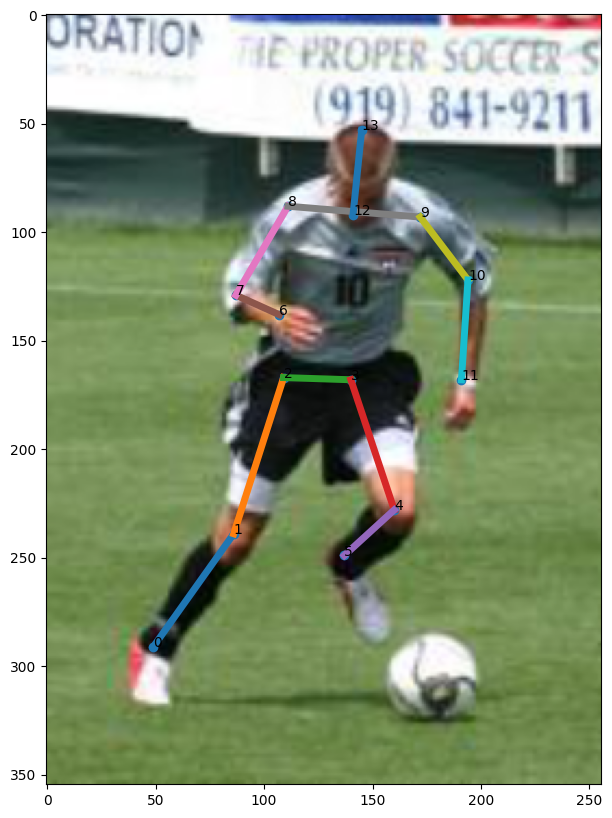

In [8]:
batch = next(batch_iter)
image = batch["images"]
keypoints = batch["keypoints"]
image_visualized = batch["images_visualized"]

visualize_keypoints(image,keypoints,image_visualized)

In [9]:
images = []
keypoints_array = []

for batch in dataloader_train:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalize_keypoints(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)

# Since the dataset is small, we can also use the test dataset for training
# Iterate over the test dataset and store the images and keypoints
for batch in dataloader_test:
    image = batch["images"]
    keypoints = batch["keypoints"].numpy().astype(np.float32)
    keypoints = keypoints[:,0:2]
    image_visualized = batch["images_visualized"].numpy()
    height,width = image_visualized.shape[:2]
    keypoints = normalize_keypoints(keypoints,(width/2,height/2,width,height))
    image = cv2.resize(image.numpy(),(220,220)).astype(np.float32)/255.0
    images.append(image)
    keypoints_array.append(keypoints)

# Convert the images and keypoints_array to numpy arrays
images = np.array(images)
keypoints_array = np.array(keypoints_array,dtype=np.float32)

In [10]:
def get_model(output = 14*2):
    model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(96,(11,11),strides=(4,4),activation="relu",input_shape=(220,220,3)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(256,(5,5),activation="relu",padding="same"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2),strides=(2,2)),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(384,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Conv2D(256,(3,3),activation="relu"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPool2D((2,2)),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(4096,activation="relu"),
                                        tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(output,activation="linear")])
    return model


In [11]:
model = get_model()

In [12]:
def loss_fn(y_true,y_pred):
    y_pred = tf.reshape(y_pred,(-1,14,2))
    return tf.reduce_sum(tf.square(y_true-y_pred))

In [13]:
sample = images[0]
sample = cv2.resize(sample,(220,220)).astype(np.float32)/255.0
sample = np.expand_dims(sample,axis=0)
sample = tf.convert_to_tensor(sample,dtype=tf.float32)
pred = model(sample)

In [14]:
loss_fn(keypoints_array[0],pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1281952>

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=loss_fn)

In [ ]:
model.fit(images,keypoints_array,epochs=1,batch_size=2,validation_split=0.1,shuffle=True,verbose=1)

900/900 [==============================] - 396s 437ms/step - loss: 19.1262 - val_loss: 1.7276


In [ ]:
model.save("deeppose.h5")

In [ ]:
model = tf.keras.models.load_model("deeppose.h5",custom_objects={"loss_fn":loss_fn})

In [ ]:
def get_preds(model,image):
    image= cv2.resize(image,(220,220))
    image = np.expand_dims(image,axis=0)
    image = tf.convert_to_tensor(image,dtype=tf.float32)
    pred = model(image)
    pred = tf.reshape(pred,(14,2))
    return pred

In [ ]:
test_iter = iter(dataloader_test)

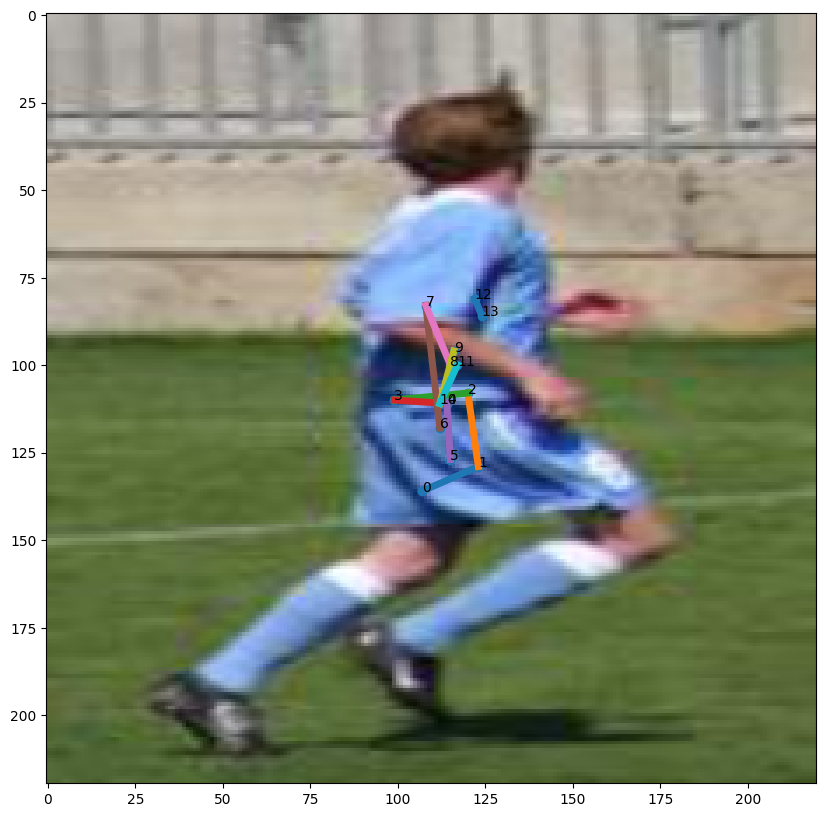

In [ ]:
img = next(test_iter)["images"].numpy()
img = cv2.resize(img,(220,220))
image = cv2.resize(img,(220,220)).astype(np.float32)/255.0
pred = get_preds(model,image).numpy()
keypoints = unnormalize_keypoints(pred,(110,110,220,220))
visualize_keypoints(img,keypoints,img)

In [ ]:
for i in range(keypoints_array.shape[0]):
    keypoints_array[i] = unnormalize_keypoints(keypoints_array[i],(110,110,220,220)).astype(np.int32)

In [ ]:
diams = []
for i,image in enumerate(images):
    diams.append(np.sqrt(np.sum(np.square(keypoints_array[i][8]-keypoints_array[i][3]))))
diams = np.array(diams)

In [ ]:
SIGMA = 1.25

In [ ]:
preds = model(images)
preds = tf.reshape(preds,(-1,14,2)).numpy()

In [ ]:
for i in range(preds.shape[0]):
    preds[i] = unnormalize_keypoints(preds[i],(110,110,220,220))

In [ ]:
keypoints_errors = keypoints_array - preds

In [ ]:
def crop_and_resize(image,bounding_box):
    x,y,w,h = bounding_box
    top_left_x = int(max(0,x-(w//2)))
    top_left_y = int(max(0,y-(h//2)))
    bottom_right_x = int(min(image.shape[1],x+(w//2)))
    bottom_right_y = int(min(image.shape[0],y+(h//2)))
    image = image[top_left_y:bottom_right_y,top_left_x:bottom_right_x]
    image = cv2.resize(image,(220,220))
    return image

In [ ]:
bounding_boxes = []
for i in range(keypoints_array.shape[0]):
    bounding_box_per_image = []
    for k in range(14):
        x,y = keypoints_array[i][k]
        bounding_box_per_image.append([x,y,SIGMA*diams[i]+0.0001,SIGMA*diams[i]+0.0001])
    bounding_box_per_image = np.array(bounding_box_per_image)
    bounding_boxes.append(bounding_box_per_image)
bounding_boxes = np.array(bounding_boxes)

In [ ]:
for i in range(keypoints_errors.shape[0]):
    for k in range(keypoints_errors.shape[2]):
        keypoints_errors[i,k,:] = normalize_keypoints(np.array([keypoints_errors[i,k,:]]),bounding_boxes[i,k])

In [ ]:
cascade_model = get_model(2)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
def loss_fn_cascade(y_true,y_pred):
    return tf.reduce_sum(tf.square(y_true-y_pred))

In [ ]:
@tf.function
def train_step(image,keypoints_errors):
    with tf.GradientTape() as tape:
        pred = cascade_model(image)
        loss_value = loss_fn_cascade(keypoints_errors,pred)
    grads = tape.gradient(loss_value,cascade_model.trainable_weights)
    optimizer.apply_gradients(zip(grads,cascade_model.trainable_weights))
    return loss_value

# Function to train the model
def train(epochs):
    for epoch in range(epochs):
        loss_value = 0
        for i in range(images.shape[0]):
            for k in range(14):
                image = crop_and_resize(images[i],bounding_boxes[i,k])
                image = np.expand_dims(image,axis=0)
                image = tf.convert_to_tensor(image,dtype=tf.float32)
                keypoints_error = keypoints_errors[i,k]
                keypoints_error = np.expand_dims(keypoints_error,axis=0)
                keypoints_error = tf.convert_to_tensor(keypoints_error,dtype=tf.float32)
                loss_value += train_step(image,keypoints_error)
            if(i%100==0):
                print(f"{i} images done with loss {loss_value.numpy()} for epoch {epoch}")
        print(f"Epoch {epoch} done with loss {loss_value.numpy()}")

In [ ]:
train(epochs=1)

0 images done with loss 31437.302734375 for epoch 0
100 images done with loss 3264568.0 for epoch 0
200 images done with loss 6524704.0 for epoch 0
300 images done with loss 9827444.0 for epoch 0
400 images done with loss 12908757.0 for epoch 0
500 images done with loss 16092432.0 for epoch 0
600 images done with loss 19283154.0 for epoch 0
700 images done with loss 22478612.0 for epoch 0
800 images done with loss 25551682.0 for epoch 0
900 images done with loss 28536596.0 for epoch 0
1000 images done with loss 31530616.0 for epoch 0
1100 images done with loss 34507504.0 for epoch 0
1200 images done with loss 37479776.0 for epoch 0
1300 images done with loss 40551884.0 for epoch 0
1400 images done with loss 43115124.0 for epoch 0
1500 images done with loss 46063440.0 for epoch 0
1600 images done with loss 48743416.0 for epoch 0
1700 images done with loss 51465340.0 for epoch 0
1800 images done with loss 54315492.0 for epoch 0
1900 images done with loss 57070908.0 for epoch 0
Epoch 0 do

In [ ]:
  cascade_model.save("deeppose_cascade_model.h5")

NameError: ignored